<a href="https://colab.research.google.com/github/Mjboothaus/rewarding-risk/blob/main/notebooks/PortfolioVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Value at Risk (VaR) of a stock portfolio using Python

## What is Value at risk (VaR)?

Value at risk (VaR) is a statistic used to try and quantify the level of financial risk within a firm or portfolio over a specified time frame. VaR provides an estimate of the maximum loss from a given position or portfolio over a period of time, and you can calculate it across various confidence levels.

Estimating the risk of a portfolio is important to long-term capital growth and risk management, particularly within larger firms or institutions. VaR is typically framed as something like this:

"We have a portfolio VaR of 250,000 USD over the next month at 95% confidence"
This means that, with 95% confidence, we can say that the portfolio's loss will not exceed 250,000 USD in a month
In this post I'll walk you through the steps to calculate this metric across a portfolio of stocks.


## How is VaR calculated?

There are two main ways to calculate VaR:
1. Using Monte Carlo simulation
2. Using the variance-covariance method

In this post, we'll focus on using method (2) (variance-covariance). In short, the variance-covariance method looks at historical price movements (standard deviation, mean price) of a given equity or portfolio of equities over a specified lookback period, and then uses probability theory to calculate the maximum loss within your specified confidence interval. You can read more detail here, but we'll calculate it step by step below using Python.

Before we get started, note that the standard VaR calculation assumes the following:
1. Normal distribution of returns - VaR assumes the returns of the portfolio are normally distributed. This is of course not realistic for most assets, but allows us to develop a baseline using a much more simplistic calculation.
(Modifications can be made to VaR to account for different distributions, but here we'll focus on the standard VaR calculation)
2. Standard market conditions - Like many financial instruments, VaR is best used for considering loss in standard markets, and is not well-suited for extreme/outlier events.

## Steps to calculate the VaR of a portfolio

In order to calculate the VaR of a portfolio, you can follow the steps below:
1. Calculate periodic returns of the stocks in the portfolio
2. Create a covariance matrix based on the returns
3. Calculate the portfolio mean and standard deviation
(weighted based on investment levels of each stock in portfolio)
4. Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean
5. Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step (4)

### Reference

https://www.interviewqs.com/blog/value-at-risk

### 0) Setup

In [32]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm


### 1) Calculate periodic returns of the stocks in the portfolio

In [33]:
# Create our portfolio of equities
tickers = ["AAPL", "META", "C", "DIS"]

# Set the investment weights (I arbitrarily picked for example)
weights = np.array([0.25, 0.3, 0.15, 0.3])

# Set an initial investment level (1M USD - for this US-centric example)
initial_investment = 1_000_000


In [34]:
assert sum(weights) == 1.0


In [35]:
# Download closing prices

data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())["Close"]

data.tail()


Symbols,AAPL,META,C,DIS
Date,,,,
2022-06-24,141.660004,170.160004,47.860001,97.779999
2022-06-27,141.660004,169.490005,47.830002,96.610001
2022-06-28,137.440002,160.679993,47.209999,95.919998
2022-06-29,139.229996,163.940002,47.099998,95.650002
2022-06-30,136.720001,161.250000,45.990002,94.400002


In [36]:
# From the closing prices, calculate periodic returns
returns = data.pct_change()

returns.tail()


Symbols,AAPL,META,C,DIS
Date,,,,
2022-06-24,0.024517,0.071874,0.032578,0.036903
2022-06-27,0.000000,-0.003937,-0.000627,-0.011966
2022-06-28,-0.029790,-0.051980,-0.012963,-0.007142
2022-06-29,0.013024,0.020289,-0.002330,-0.002815
2022-06-30,-0.018028,-0.016408,-0.023567,-0.013068


### 2) Create a covariance matrix based on the returns

This will allow us to calculate the standard deviation and mean of returns across the entire portfolio.

In [37]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()

cov_matrix


Symbols,AAPL,META,C,DIS
Symbols,,,,
AAPL,0.000439,0.000318,0.000246,0.000194
META,0.000318,0.000657,0.000232,0.000211
C,0.000246,0.000232,0.000614,0.000304
DIS,0.000194,0.000211,0.000304,0.000399


### 3) Calculate the portfolio mean and standard deviation

In [38]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, using dot product to
# normalize individual means against investment weights

# https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.

port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation

port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment

mean_investment = (1 + port_mean) * initial_investment

# Calculate standard deviation of investment

stdev_investment = initial_investment * port_stdev


In [39]:
avg_rets


Symbols
AAPL    0.001242
META    0.000232
C      -0.000116
DIS     0.000049
dtype: float64

In [40]:
port_mean


0.0003771790522696406

In [41]:
port_stdev


0.017826366891472527

In [42]:
mean_investment


1000377.1790522698

In [43]:
stdev_investment


17826.366891472528

Next, we can plug these variables into our percentage point function (PPF) below.

### 4) Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean

In [44]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution

# Plugging in the mean, standard deviation of our portfolio
# as calculated above

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)


In [45]:
cutoff1


971055.4148154636

### 5) Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step 4

In [46]:
# Finally, we can calculate the VaR at our confidence interval

var_1d1 = initial_investment - cutoff1

var_1d1


28944.58518453641

Here we are saying with 95% confidence that our portfolio of 1M USD will not exceed losses greater than 28.9k USD over a one day period.

### Value at risk over $n$-day time period

What if we wanted to calculate this over a larger window of time? Below we can easily do that by just taking our 1 day VaR and multiplying it by the square root of the time period (this is due to the fact that the standard deviation of stock returns tends to increase with the square root of time).

In [47]:
# Calculate n Day VaR

var_array = []

num_days = 15

for x in range(1, num_days + 1):
    var_array.append(np.round(var_1d1 * np.sqrt(x), 2))
    print(
        f"{str(x)} day VaR @ 95% confidence: {str(np.round(var_1d1 * np.sqrt(x), 2))}"
    )


1 day VaR @ 95% confidence: 28944.59
2 day VaR @ 95% confidence: 40933.82
3 day VaR @ 95% confidence: 50133.49
4 day VaR @ 95% confidence: 57889.17
5 day VaR @ 95% confidence: 64722.06
6 day VaR @ 95% confidence: 70899.46
7 day VaR @ 95% confidence: 76580.17
8 day VaR @ 95% confidence: 81867.65
9 day VaR @ 95% confidence: 86833.76
10 day VaR @ 95% confidence: 91530.82
11 day VaR @ 95% confidence: 95998.33
12 day VaR @ 95% confidence: 100266.98
13 day VaR @ 95% confidence: 104361.19
14 day VaR @ 95% confidence: 108300.72
15 day VaR @ 95% confidence: 112101.9


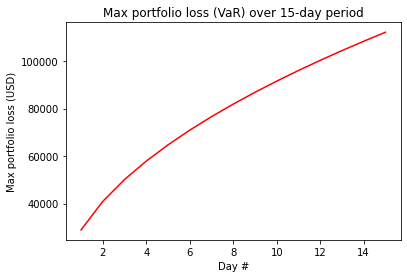

In [48]:
# Build plot

plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(range(1, num_days + 1), var_array, "r")


### (Extra) Checking distributions of our equities against normal distribution

As mentioned in the calculation section, we are assuming that the returns of the equities in our portfolio are normally distributed when calculating VaR. Of course, we can't predict that moving forward, but we can at least check how the historical returns have been distributed to help us assess whether VaR is suitable to use for our portfolio.

In [49]:
def plot_return_dist(ticker):
    returns[ticker].hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
    x = np.linspace(port_mean - 3 * port_stdev, port_mean + 3 * port_stdev, 100)
    plt.plot(x, norm.pdf(x, port_mean, port_stdev), "r")
    plt.title(f"{ticker} returns (binned) vs. normal distribution")
    plt.show()


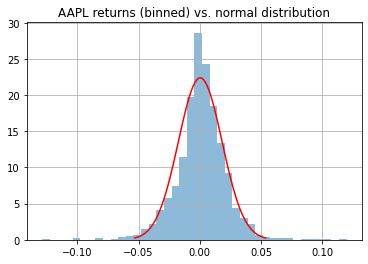

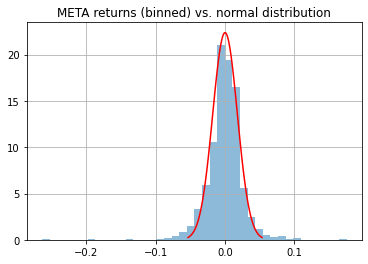

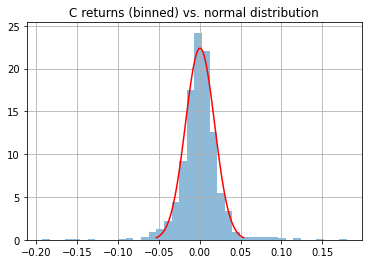

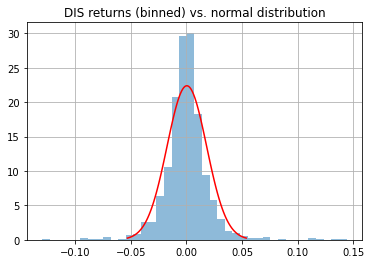

In [50]:
for ticker in tickers:
    plot_return_dist(ticker)


From the above we can see the returns are rarely normally distributed for our chosen stocks since 2018.